In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

TIMESERIES_CONTEXT = 16
BATCH_SIZE = 64
NUM_HEADS = 2
HEAD_SIZE = 64
DROPOUT = 0.2

t = np.arange(0, 10*2*np.pi, 0.001)
data = np.sin(t)
data = tf.data.Dataset.from_tensor_slices(data)

X = data.window(size=TIMESERIES_CONTEXT, shift=1, drop_remainder=True)\
        .flat_map(lambda x: x.batch(TIMESERIES_CONTEXT))
y = data.skip(1)\
        .window(size=TIMESERIES_CONTEXT, shift=1, drop_remainder=True)\
        .flat_map(lambda x: x.batch(TIMESERIES_CONTEXT))
training = tf.data.Dataset.zip((X, y))\
                          .shuffle(buffer_size=1000)\
                          .batch(BATCH_SIZE)

class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, context, embed_dim):
        super().__init__()
        self.context = context
        self.input_embedding = tf.keras.layers.Dense(embed_dim)
        self.position_embedding = tf.keras.layers.Embedding(context, embed_dim)
        self.reshape = tf.keras.layers.Reshape(target_shape=(context,1))
    
    def call(self, x):
        # return self.reshape(x)
        return self.input_embedding(self.reshape(x)) + self.position_embedding(0*x + tf.range(self.context, dtype=tf.float32))

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, head_size, dropout):
        super().__init__()
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        self.feed_forward = tf.keras.Sequential([tf.keras.layers.Dense(4*num_heads*head_size, activation='relu'),
                                                 tf.keras.layers.Dense(num_heads*head_size),
                                                 tf.keras.layers.Dropout(dropout)])
    
    def call(self, x):
        norm_x = self.layer_norm1(x)
        attn = x + self.attention(norm_x, norm_x, use_causal_mask=True)
        norm_attn = self.layer_norm2(attn)
        feed_fwd = attn + self.feed_forward(norm_attn)
        return feed_fwd


inp1 = tf.keras.layers.Input(shape=(TIMESERIES_CONTEXT,))  # (B, T)
layer = PositionEmbedding(TIMESERIES_CONTEXT, NUM_HEADS*HEAD_SIZE)(inp1)
layer = TransformerBlock(num_heads=NUM_HEADS, head_size=HEAD_SIZE, dropout=DROPOUT)(layer)
#layer = tf.keras.layers.LSTM(NUM_HEADS*HEAD_SIZE, return_sequences=True)(layer)
#layer = tf.keras.layers.Dense(4*NUM_HEADS*HEAD_SIZE, activation='relu')(layer)
layer = tf.keras.layers.LayerNormalization()(layer)
layer = tf.keras.layers.Dense(1)(layer)

model = tf.keras.models.Model(inputs=inp1, outputs=layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(training, epochs=5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 position_embedding_2 (Posit  (None, 16, 128)          2304      
 ionEmbedding)                                                   
                                                                 
 transformer_block_1 (Transf  (None, 16, 128)          198272    
 ormerBlock)                                                     
                                                                 
 layer_normalization_6 (Laye  (None, 16, 128)          256       
 rNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 16, 1)             129       
                                                           

982/982 [==============================] - 15s 15ms/step


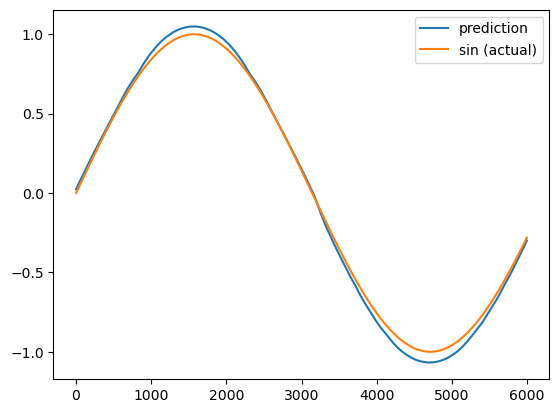

In [52]:
# Create a test dataset - same as training but we don't shuffle it
test = tf.data.Dataset.zip((X, y))\
                      .batch(BATCH_SIZE)
pred = model.predict(test)

# Plot the model's predictions alongside an actual sin wave
plt.plot(np.array([p[-1][0] for p in pred])[0:6000])
plt.plot(np.sin(t)[0:6000])
plt.legend(['prediction', 'sin (actual)'])